In [3]:
import os
import sys
import random

import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append(os.path.join('..', '..', 'tta_uia_segmentation', 'src'))

from dataset.dataset_in_memory_for_ddpm import get_datasets as get_datasets_with_nn
from dataset.dataset_in_memory import get_datasets as get_datasets_without_nn  
from tta_uia_segmentation.src.models.io import load_norm_from_configs_and_cpt, load_norm_and_seg_from_configs_and_cpt
from tta_uia_segmentation.src.utils.io import load_config
from tta_uia_segmentation.src.dataset.utils import onehot_to_class
from tta_uia_segmentation.src.utils.visualization import plot_img_seg
from tta_uia_segmentation.src.utils.loss import dice_score, DescriptorRegularizationLoss
from tta_uia_segmentation.src.utils.utils import uniform_interval_sampling


In [4]:
dataset_name        = 'hcp_t1'
split               = 'val'
seg_model_dir       = '/scratch_net/biwidl319/jbermeo/data/models/brain/segmentation/hcp_t1/no_bg_supp_norm_w_3x3_conv'
device              = 'cuda' if torch.cuda.is_available() else 'cpu' 

model_params        = load_config('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/config/models.yaml')
dataset_params      = load_config('/scratch_net/biwidl319/jbermeo/MastersThesisUIASegmentation/config/datasets.yaml')
dataset_params      = dataset_params[dataset_name]

reg_losses          = {
    'zncc': DescriptorRegularizationLoss('zncc'),
    'sift': DescriptorRegularizationLoss('sift', patch_size=256, num_ang_bins=8, num_spatial_bins=16),
    'mi':   DescriptorRegularizationLoss('mi', sigma=0.1, num_bins=256) 
    }

# Load normalization and segmentation model
norm, seg = load_norm_and_seg_from_configs_and_cpt(
    n_classes=dataset_params['n_classes'],
    model_params_norm=model_params['normalization_2D'],
    model_params_seg=model_params['segmentation_2D'],
    cpt_fp=os.path.join(seg_model_dir, 'checkpoint_best.pth'),
    device=device    
)     
norm.eval()
seg.eval()

# Load dataset with normalized images with nn (val)
(ds_normalized,) = get_datasets_with_nn(
        splits          = [split],
        norm            = norm,   
        paths           = dataset_params['paths_processed'],
        paths_original  = dataset_params['paths_original'], 
        image_size      = (1, 256, 256),
        resolution_proc = dataset_params['resolution_proc'],
        dim_proc        = dataset_params['dim'],
        n_classes       = dataset_params['n_classes'],
        aug_params      = None,
        deformation     = None,
        load_original   = True,
        normalize       = 'none',
        bg_suppression_opts = None
    )

# Load dataset with original preprocessed images (val)
(ds, )  = get_datasets_without_nn(
        splits          = [split],
        paths           = dataset_params['paths_processed'],
        paths_original  = dataset_params['paths_original'], 
        image_size      = (1, 256, 256),
        resolution_proc = dataset_params['resolution_proc'],
        dim_proc        = dataset_params['dim'],
        n_classes       = dataset_params['n_classes'],
        aug_params      = None,
        deformation     = None,
        load_original   = True,
        bg_suppression_opts = None
    )

/scratch_net/biwidl319/jbermeo/GNN-Domain-Generalization-main/net_scratch/conda_envs/tta_uia_seg/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Determining min and max values of normalized images from a sample of 256 images
Min and max values of normalized images: -0.8592404127120972, 0.31760573387145996


### Sampled images


In [5]:
# For random Image
# vol_idx_sd = random.randint(0, ds_normalized.num_vols - 1)
# slice_idx = random.randint(0, 47)
# img_idx = ds_normalized.vol_and_z_idx_to_idx(vol_idx_sd, slice_idx)

img_idx = 128
original_img = ds[img_idx][0][0]
y_gt_onehot = ds[img_idx][1][None]
y_gt = onehot_to_class(ds[img_idx][1][None]).squeeze()

nn_normalized_img = ds_normalized[img_idx][0][0]

ds_normalized.normalize = 'min_max'
nn_normalized_img_btw_0_1 = ds_normalized[img_idx][0][0]

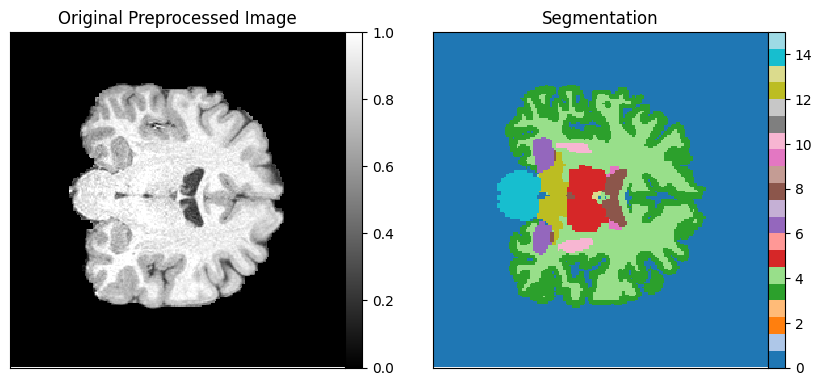

In [6]:
plot_img_seg(
    img=original_img, seg=y_gt, n_classes=dataset_params['n_classes'],
    img_title='Original Preprocessed Image', 
    seg_title='Segmentation')

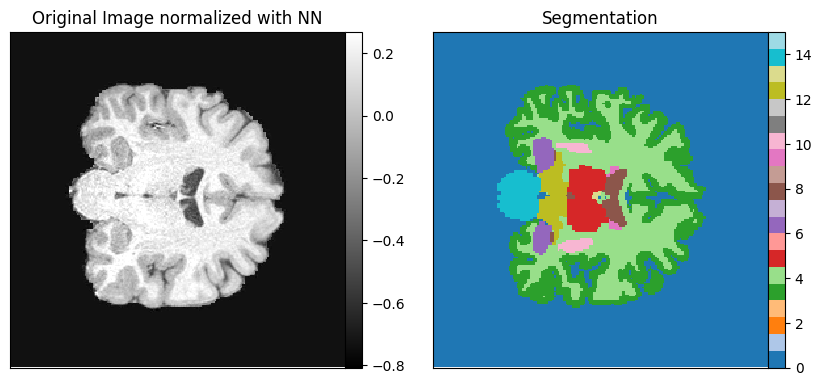

In [7]:
plot_img_seg(
    img=nn_normalized_img, seg=y_gt, n_classes=dataset_params['n_classes'],
    img_title='Original Image normalized with NN', 
    seg_title='Segmentation')

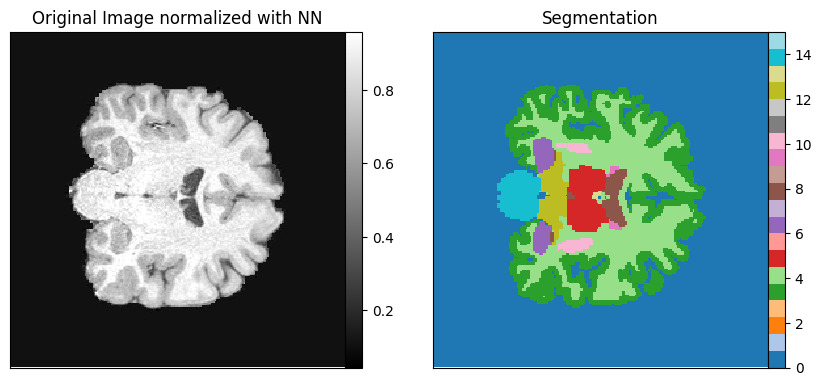

In [8]:
plot_img_seg(
    img=nn_normalized_img_btw_0_1, seg=y_gt, n_classes=dataset_params['n_classes'],
    img_title='Original Image normalized with NN', 
    seg_title='Segmentation')

In [9]:
for reg_loss_name, reg_loss in reg_losses.items():
    print(f'Computing {reg_loss_name} loss')
    print('-' * 50)
    
    print('nn_normalized_img vs. nn_normalized_img_btw_0_1: '
          f'{reg_loss(nn_normalized_img[None, None], nn_normalized_img_btw_0_1[None, None]).item()}')
    
    print('original_img vs. nn_normalized_img: ' 
          f'{reg_loss(nn_normalized_img[None, None], original_img[None, None]).item()}')
    
    print('original_img vs. nn_normalized_img_btw_0_1: '
          f'{reg_loss(nn_normalized_img_btw_0_1[None, None], original_img[None, None]).item()}')
    
    print('original_img vs. original_img: '
          f'{reg_loss(original_img[None, None], original_img[None, None]).item()}')
    
    print('\n\n')

Computing zncc loss
--------------------------------------------------
nn_normalized_img vs. nn_normalized_img_btw_0_1: 0.0


original_img vs. nn_normalized_img: 7.295608520507812e-05
original_img vs. nn_normalized_img_btw_0_1: 7.271766662597656e-05
original_img vs. original_img: 0.0



Computing sift loss
--------------------------------------------------
nn_normalized_img vs. nn_normalized_img_btw_0_1: 5.655821366801206e-10
original_img vs. nn_normalized_img: 3.333784093229042e-07
original_img vs. nn_normalized_img_btw_0_1: 3.3461921589150734e-07
original_img vs. original_img: 0.0



Computing mi loss
--------------------------------------------------
nn_normalized_img vs. nn_normalized_img_btw_0_1: 0.363004207611084
original_img vs. nn_normalized_img: 0.7468063831329346
original_img vs. nn_normalized_img_btw_0_1: 0.4991615414619446
original_img vs. original_img: 0.39238643646240234





In [10]:
# Let's drop mi for now
del reg_losses['mi']

## Invalid images via very bad contrast

In [11]:
def gamma_contrast_change(images_: np.ndarray, gamma: float):
    return images_** gamma
        

In [30]:
torch.quantile(original_img, 0.99)

tensor(1.)

(array([1.000e+00, 1.200e+01, 9.000e+00, 7.000e+00, 1.200e+01, 1.400e+01,
        1.300e+01, 1.800e+01, 1.800e+01, 4.200e+01, 6.300e+01, 9.100e+01,
        1.160e+02, 1.380e+02, 1.330e+02, 1.420e+02, 1.270e+02, 1.270e+02,
        1.110e+02, 1.250e+02, 1.090e+02, 1.290e+02, 1.290e+02, 1.380e+02,
        1.400e+02, 1.630e+02, 1.620e+02, 1.980e+02, 2.360e+02, 2.770e+02,
        3.560e+02, 4.560e+02, 5.570e+02, 6.530e+02, 7.930e+02, 8.810e+02,
        9.560e+02, 8.980e+02, 8.590e+02, 8.270e+02, 7.260e+02, 7.610e+02,
        8.470e+02, 1.019e+03, 1.312e+03, 1.595e+03, 1.613e+03, 1.458e+03,
        1.049e+03, 1.759e+03]),
 array([0.00499844, 0.02489847, 0.0447985 , 0.06469853, 0.08459856,
        0.10449859, 0.12439863, 0.14429866, 0.1641987 , 0.18409872,
        0.20399874, 0.22389878, 0.24379881, 0.26369885, 0.28359887,
        0.30349889, 0.32339895, 0.34329897, 0.363199  , 0.38309902,
        0.40299907, 0.4228991 , 0.44279912, 0.46269915, 0.4825992 ,
        0.50249922, 0.52239925, 0.54

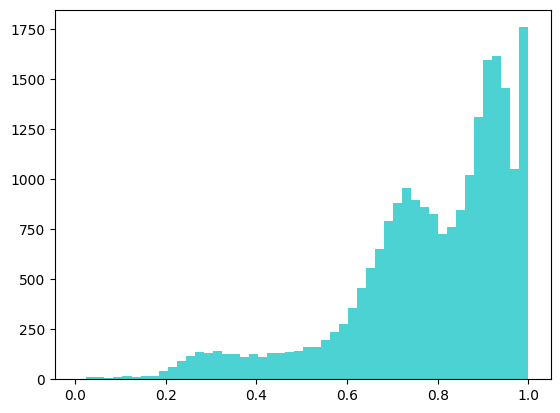

In [12]:
plt.hist([x for x in original_img.flatten() if x > 0], bins=50, color='c', alpha=0.7)


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 4.000e+00,
        3.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 4.000e+00, 5.000e+00,
        1.000e+00, 7.000e+00, 5.000e+00, 8.000e+00, 8.000e+00, 1.000e+01,
        8.000e+00, 1.400e+01, 2.900e+01, 4.300e+01, 9.800e+01, 1.360e+02,
        1.860e+02, 2.030e+02, 2.170e+02, 2.020e+02, 2.380e+02, 2.810e+02,
        3.310e+02, 4.860e+02, 8.650e+02, 1.803e+03, 3.080e+03, 2.987e+03,
        4.464e+03, 6.637e+03]),
 array([0.76725852, 0.77191335, 0.77656817, 0.781223  , 0.78587782,
        0.79053265, 0.79518747, 0.79984236, 0.80449718, 0.80915201,
        0.81380683, 0.81846166, 0.82311648, 0.82777131, 0.83242613,
        0.83708096, 0.84173578, 0.8463906 , 0.85104543, 0.85570031,
        0.86035514, 0.86500996, 0.86966479, 0.87431961, 0.87897444,
        0.88362926, 0.88828409, 0.89

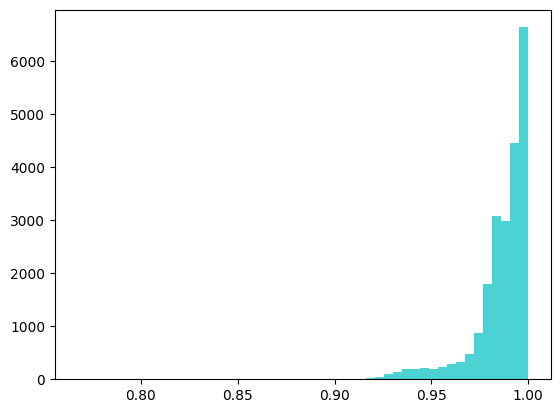

In [13]:
# Plot histogram of intensities of img
plt.hist([x for x in gamma_contrast_change(original_img, 0.05).flatten() if x > 0], bins=50, color='c', alpha=0.7)


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 1.000e+00,
        1.000e+00, 4.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 4.000e+00,
        8.000e+00, 5.000e+00, 1.000e+01, 8.000e+00, 7.000e+00, 1.600e+01,
        1.400e+01, 3.800e+01, 5.900e+01, 1.030e+02, 1.500e+02, 1.780e+02,
        1.940e+02, 2.090e+02, 1.830e+02, 2.180e+02, 2.600e+02, 2.940e+02,
        4.090e+02, 6.150e+02, 1.222e+03, 2.190e+03, 2.889e+03, 2.660e+03,
        4.547e+03, 5.857e+03]),
 array([0.58868563, 0.59691191, 0.60513818, 0.61336452, 0.62159079,
        0.62981707, 0.63804334, 0.64626962, 0.65449595, 0.66272223,
        0.67094851, 0.67917478, 0.68740106, 0.69562739, 0.70385367,
        0.71207994, 0.72030622, 0.72853249, 0.73675883, 0.7449851 ,
        0.75321138, 0.76143765, 0.76966393, 0.77789026, 0.78611654,
        0.79434282, 0.80256909, 0.81

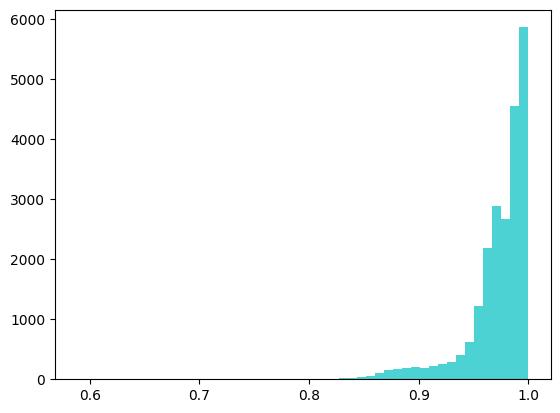

In [14]:
plt.hist([x for x in gamma_contrast_change(original_img, 0.1).flatten() if x > 0], bins=50, color='c', alpha=0.7)


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 3.000e+00,
        6.000e+00, 3.000e+00, 4.000e+00, 4.000e+00, 6.000e+00, 1.000e+00,
        9.000e+00, 7.000e+00, 9.000e+00, 9.000e+00, 7.000e+00, 1.600e+01,
        9.000e+00, 2.900e+01, 3.700e+01, 7.500e+01, 8.600e+01, 1.220e+02,
        1.330e+02, 1.390e+02, 1.340e+02, 1.500e+02, 1.300e+02, 1.290e+02,
        1.400e+02, 1.580e+02, 1.640e+02, 1.850e+02, 1.920e+02, 2.400e+02,
        3.010e+02, 3.810e+02, 5.570e+02, 8.220e+02, 1.089e+03, 1.361e+03,
        1.509e+03, 1.395e+03, 1.277e+03, 1.356e+03, 1.898e+03, 2.762e+03,
        2.686e+03, 2.643e+03]),
 array([0.07069965, 0.08928566, 0.10787166, 0.12645766, 0.14504367,
        0.16362968, 0.18221569, 0.2008017 , 0.21938771, 0.2379737 ,
        0.25655973, 0.27514574, 0.29373172, 0.31231773, 0.33090374,
        0.34948975, 0.36807576, 0.38666177, 0.40524778, 0.42383379,
        0.4424198 , 0.46100581, 0.47959182, 0.4981778 , 0.51676381,
        0.53534985, 0.55393583, 0.57

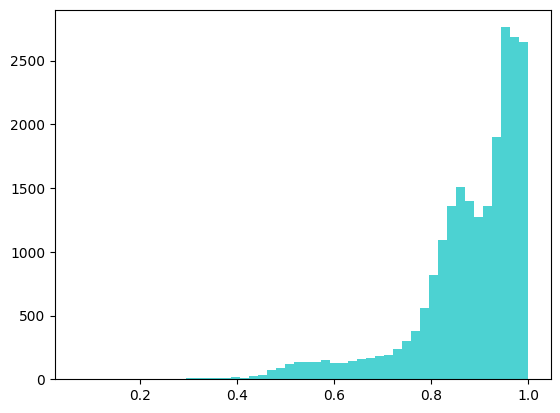

In [15]:
plt.hist([x for x in gamma_contrast_change(original_img, 0.5).flatten() if x > 0], bins=50, color='c', alpha=0.7)


(array([1.5367e+04, 1.2950e+03, 7.5000e+02, 5.4800e+02, 4.4400e+02,
        3.1100e+02, 2.5500e+02, 2.3300e+02, 2.0000e+02, 1.5400e+02,
        1.2300e+02, 1.2900e+02, 1.0400e+02, 1.0000e+02, 9.0000e+01,
        8.6000e+01, 9.5000e+01, 5.6000e+01, 7.7000e+01, 6.0000e+01,
        4.5000e+01, 4.8000e+01, 3.6000e+01, 4.2000e+01, 3.8000e+01,
        4.6000e+01, 3.0000e+01, 3.7000e+01, 2.5000e+01, 3.0000e+01,
        3.1000e+01, 2.6000e+01, 3.1000e+01, 3.2000e+01, 2.5000e+01,
        2.7000e+01, 2.5000e+01, 2.6000e+01, 2.5000e+01, 2.8000e+01,
        2.6000e+01, 1.5000e+01, 1.4000e+01, 1.5000e+01, 2.5000e+01,
        1.3000e+01, 1.7000e+01, 1.6000e+01, 1.6000e+01, 1.0600e+03]),
 array([3.92363570e-44, 1.99999996e-02, 3.99999991e-02, 5.99999987e-02,
        7.99999982e-02, 1.00000001e-01, 1.19999997e-01, 1.40000001e-01,
        1.59999996e-01, 1.80000007e-01, 2.00000003e-01, 2.19999999e-01,
        2.39999995e-01, 2.59999990e-01, 2.80000001e-01, 3.00000012e-01,
        3.19999993e-01, 3.4000

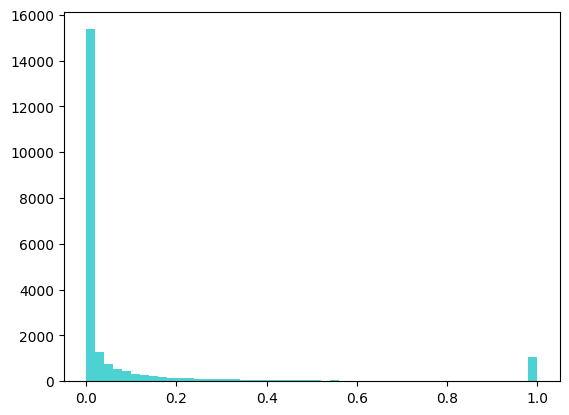

In [16]:
plt.hist([x for x in gamma_contrast_change(original_img, 40).flatten() if x > 0], bins=50, color='c', alpha=0.7)


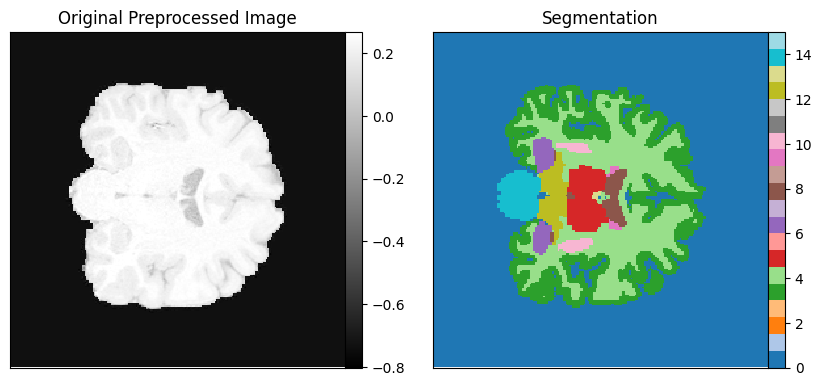

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        4.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 3.000e+00,
        6.000e+00, 1.000e+00, 5.000e+00, 7.000e+00, 5.000e+00, 9.000e+00,
        1.000e+01, 5.000e+00, 1.600e+01, 1.800e+01, 3.300e+01, 5.600e+01,
        9.000e+01, 1.200e+02, 1.570e+02, 1.750e+02, 1.640e+02, 1.900e+02,
        1.690e+02, 1.930e+02, 2.190e+02, 2.540e+02, 3.020e+02, 4.190e+02,
        6.480e+02, 1.174e+03, 1.852e+03, 2.376e+03, 2.189e+03, 2.445e+03,
        4.460e+03, 4.586e+03]),
 array([0.34655079, 0.35961977, 0.37268877, 0.38575774, 0.39882672,
        0.41189572, 0.4249647 , 0.43803367, 0.45110267, 0.46417165,
        0.47724062, 0.49030963, 0.50337863, 0.5164476 , 0.52951658,
        0.54258555, 0.55565453, 0.5687235 , 0.58179253, 0.59486151,
        0.60793048, 0.62099946, 0.63406843, 0.6471374 , 0.66020644,
        0.67327541, 0.68634439, 0.69

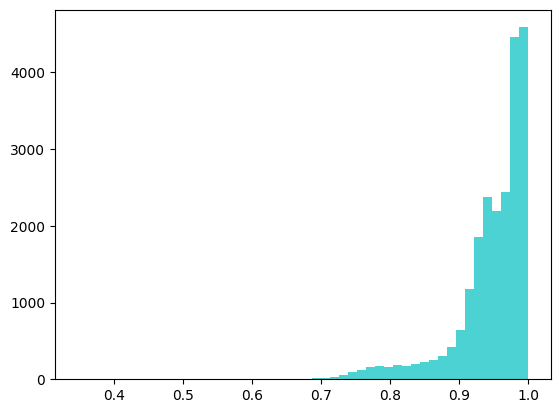

In [ ]:
gamma = 0.2
plot_img_seg(
    img=norm(gamma_contrast_change(original_img, gamma=gamma)[None, None]).squeeze(),
    seg=y_gt, n_classes=dataset_params['n_classes'],
    img_title='Original Preprocessed Image', 
    seg_title='Segmentation')

plt.hist([x for x in gamma_contrast_change(original_img, gamma).flatten() if x > 0], bins=50, color='c', alpha=0.7)


0it [00:00, ?it/s]

Gamma: 1.0
Dice Score: 0.6445478200912476
zncc: 0.0
sift: 0.0


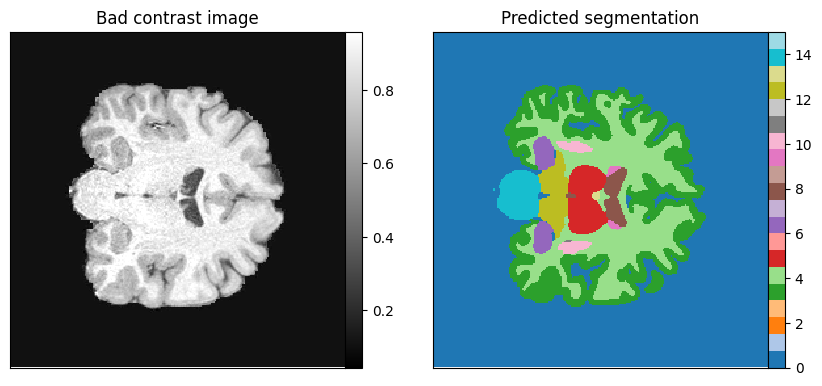

1it [00:02,  2.33s/it]

Gamma: 0.20000000000000004
Dice Score: 0.21444997191429138
zncc: 0.01120060682296753
sift: 1.0894368642766494e-05


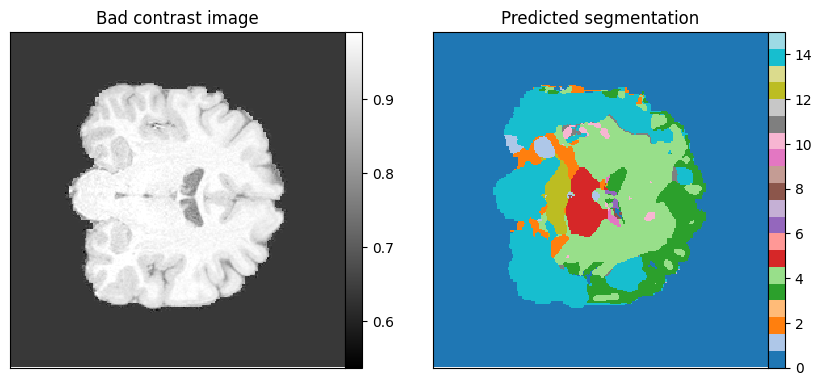

2it [00:04,  2.05s/it]

Gamma: 0.11100946155696226
Dice Score: 0.10834737122058868
zncc: 0.013560593128204346
sift: 1.4076117622607853e-05


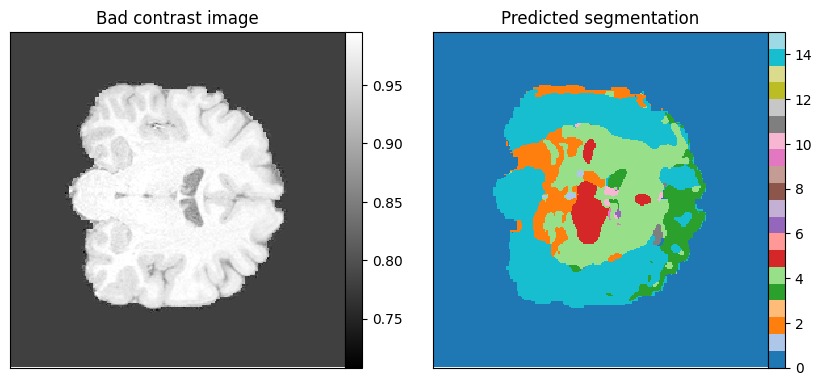

3it [00:06,  2.25s/it]

Gamma: 0.061615502775833435
Dice Score: 0.07725479453802109
zncc: 0.014933228492736816
sift: 1.6229087123065256e-05


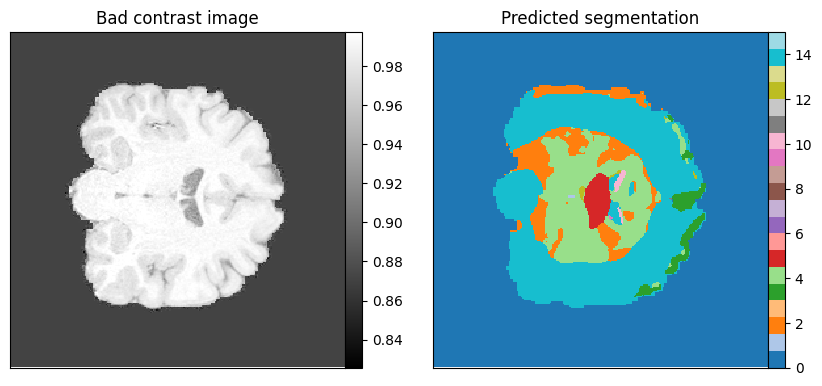

4it [00:11,  3.27s/it]

Gamma: 0.03419951893353393
Dice Score: 0.043017707765102386
zncc: 0.015712976455688477
sift: 1.7845899492385797e-05


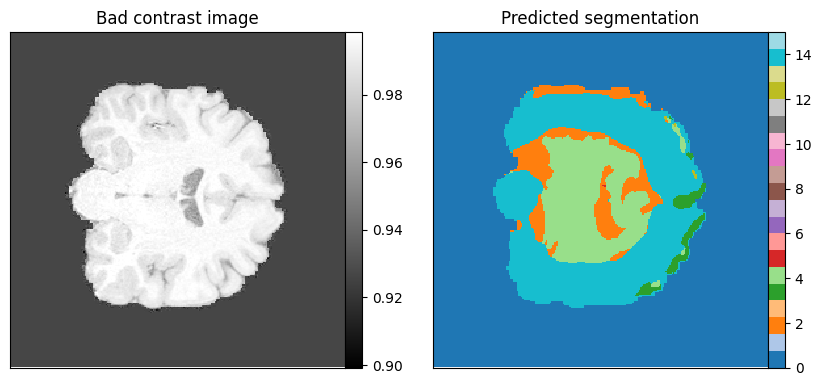

5it [00:13,  2.81s/it]

Gamma: 0.0189823509115937
Dice Score: 0.043184805661439896
zncc: 0.01615041494369507
sift: 1.9453000277280807e-05


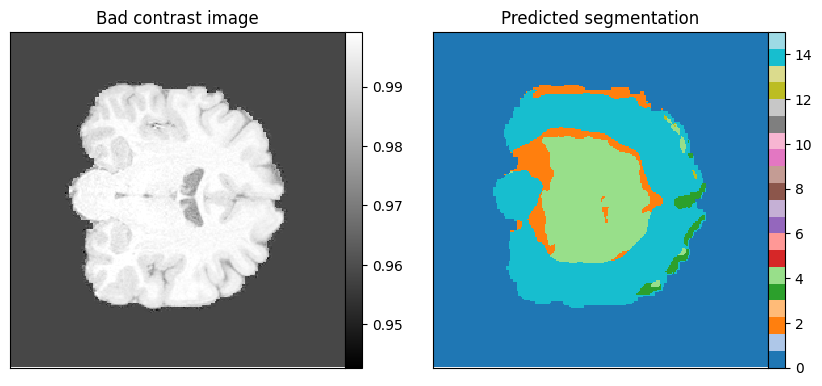

6it [00:14,  2.27s/it]

Gamma: 0.010536102768906645
Dice Score: 0.0438908152282238
zncc: 0.01639491319656372
sift: 2.165727892133873e-05


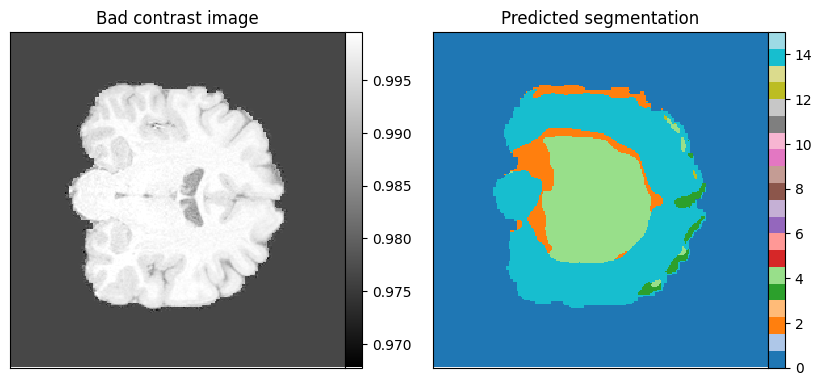

7it [00:15,  1.87s/it]

Gamma: 0.005848035476425728
Dice Score: 0.044108796864748
zncc: 0.016530632972717285
sift: 2.53060607064981e-05


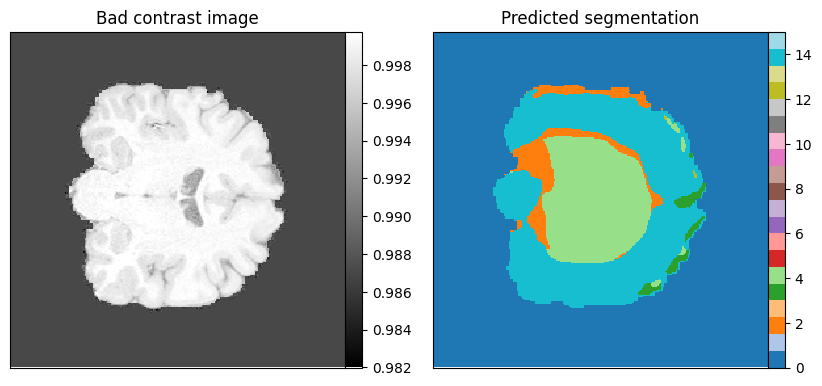

8it [00:17,  1.94s/it]

Gamma: 0.00324593634702017
Dice Score: 0.04432332515716553
zncc: 0.016606450080871582
sift: 3.1729883630760014e-05


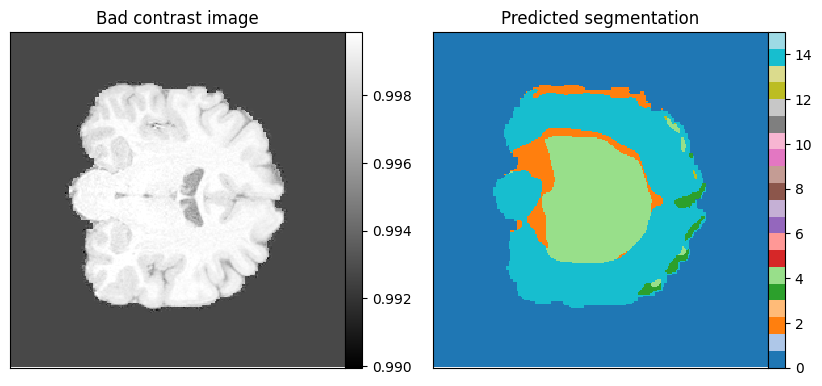

9it [00:19,  1.86s/it]

Gamma: 0.001801648230654412
Dice Score: 0.04446887597441673
zncc: 0.01664876937866211
sift: 4.3020201701438054e-05


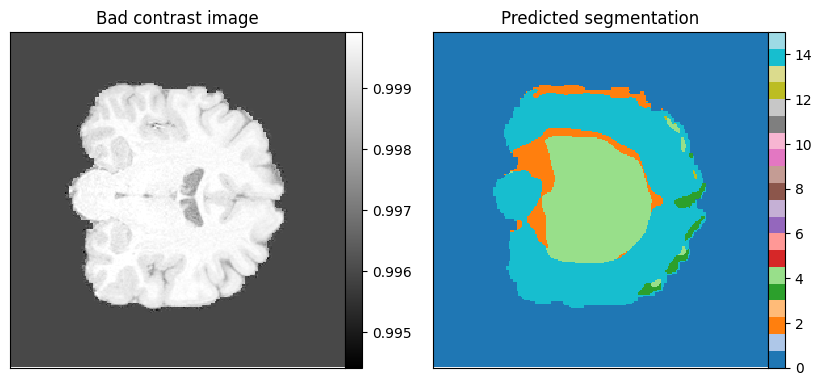

10it [00:21,  2.04s/it]

Gamma: 0.001
Dice Score: 0.044522762298583984
zncc: 0.016671419143676758
sift: 6.215542816789821e-05


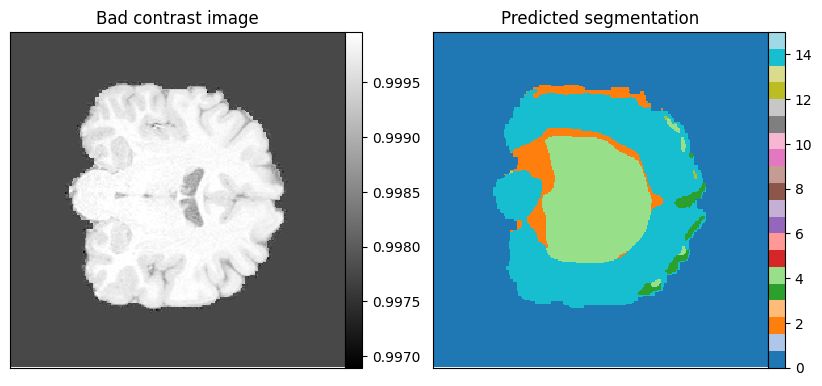

11it [00:24,  2.24s/it]


In [18]:
num_increments = 10
reg_losses_values = {k: [] for k in reg_losses.keys()}
dice_scores = []

gamma_max = 0.001
gamma_min = 0.2

# Do log sampling between 0.2 and 0.001
gammas = list(np.logspace(np.log10(0.001), np.log10(gamma_min), num=num_increments, base=10))
gammas.append(1.0)

# Iterate over increasing levels of bad contrast
for gamma in tqdm(reversed(gammas)):
    # apply bad contrast to normalized image without normalizing between 0 and 1
    img = gamma_contrast_change(nn_normalized_img_btw_0_1, gamma=gamma)
    
    # Measure regularization metric
    for reg_loss_name, reg_loss in reg_losses.items():
        reg_losses_values[reg_loss_name].append(reg_loss(nn_normalized_img_btw_0_1[None, None], img[None, None]).item())

    # Measure dice score between predicted segmentation over bad image and ground truth
    with torch.no_grad():
        mask, _ = seg(norm(gamma_contrast_change(original_img, gamma=gamma)[None, None]))
        _, dice_fg = dice_score(mask, y_gt_onehot)
        dice_scores.append(dice_fg.item())
    
    print(f'Gamma: {gamma}')
    print(f'Dice Score: {dice_fg.item()}')
    for reg_loss in reg_losses_values:
        print(f'{reg_loss}: {reg_losses_values[reg_loss][-1]}')
    plot_img_seg(
        img=img.squeeze(), seg=onehot_to_class(mask).squeeze(), n_classes=dataset_params['n_classes'],
        img_title='Bad contrast image', 
        seg_title='Predicted segmentation')
    

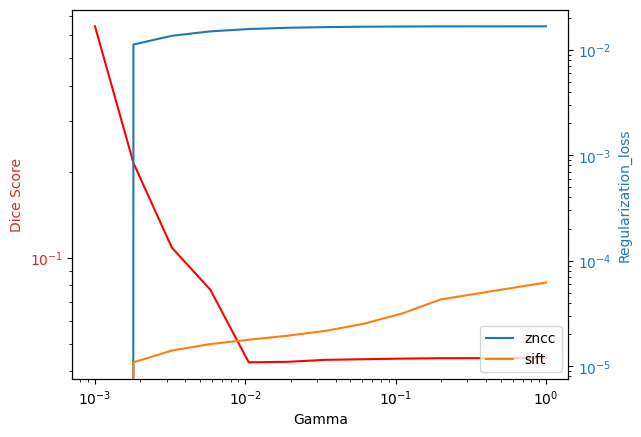

In [22]:
# Plot the regularization metrics and the dice scores  in the same line plot as a function of the bad contrast, use two y axes, one for gamma and one for the regularization metrics
fig, ax1 = plt.subplots()
ax1.set_xlabel('Gamma')
ax1.set_ylabel('Dice Score', color='tab:red')
ax1.plot(gammas, dice_scores, color='r')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Regularization_loss', color='tab:blue')
for reg_loss_name in reg_losses_values:
    ax2.plot(gammas, reg_losses_values[reg_loss_name], label=reg_loss_name)
ax2.legend()
ax2.tick_params(axis='y', labelcolor='tab:blue')

# set ax2 y axis to log scale
ax2.set_yscale('log')


0it [00:00, ?it/s]

Gamma: 1.0
Dice Score: 0.6445478200912476
zncc: 0.0
sift: 0.0


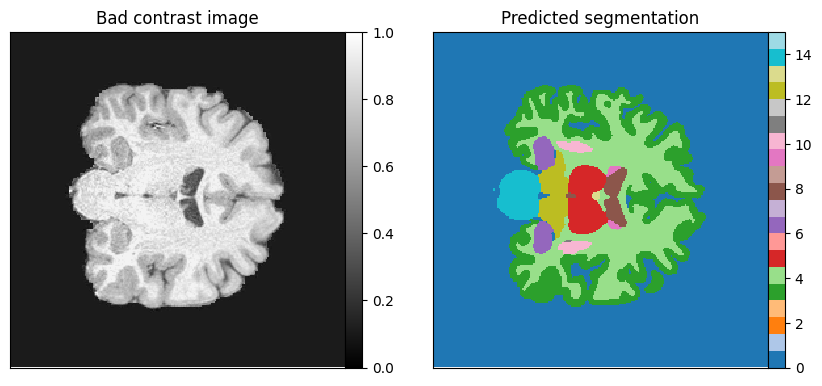

1it [00:06,  6.84s/it]

Gamma: 0.5
Dice Score: 0.6321472525596619
zncc: 0.004614472389221191
sift: 3.6897988593409536e-06


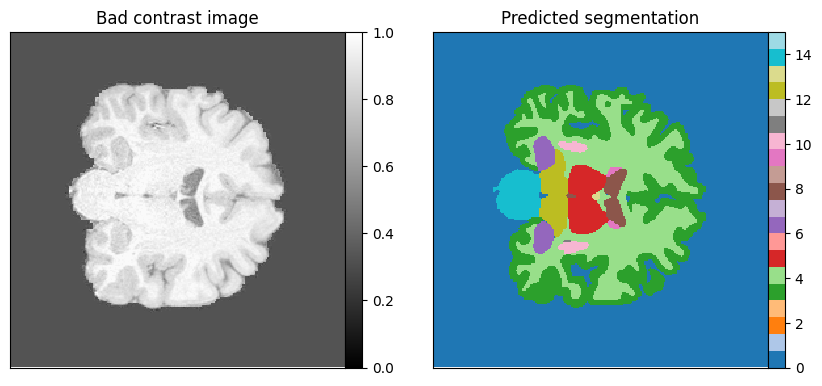

2it [00:13,  6.85s/it]

Gamma: 0.3605113577091053
Dice Score: 0.5886274576187134
zncc: 0.007382690906524658
sift: 6.451930403272854e-06


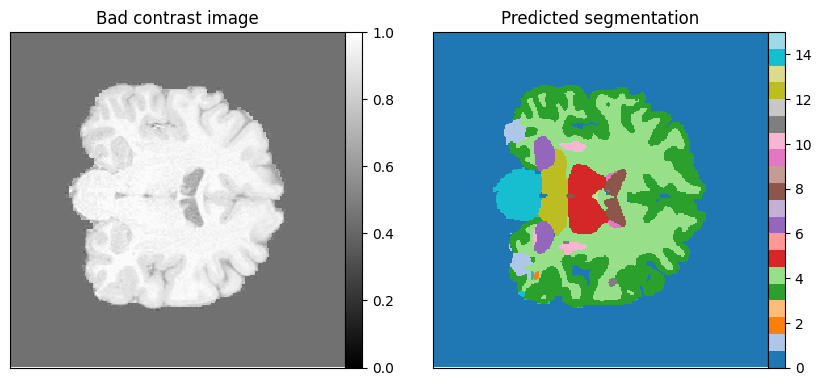

3it [00:17,  5.66s/it]

Gamma: 0.259936878074525
Dice Score: 0.3397996425628662
zncc: 0.009703457355499268
sift: 9.061444870894775e-06


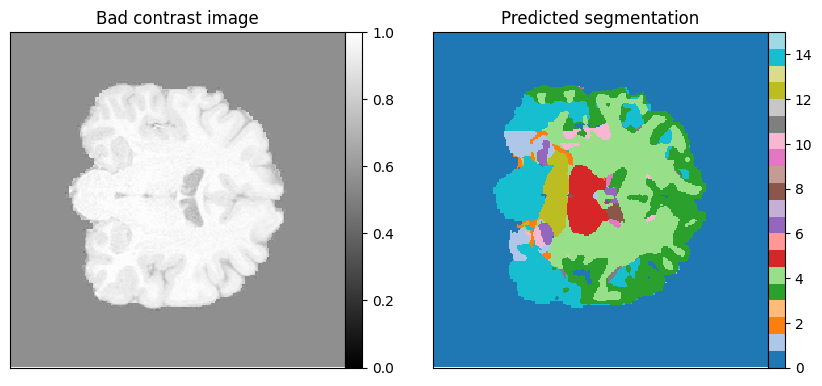

4it [00:24,  6.04s/it]

Gamma: 0.1874203936666262
Dice Score: 0.1991368979215622
zncc: 0.011524677276611328
sift: 1.1308054126857314e-05


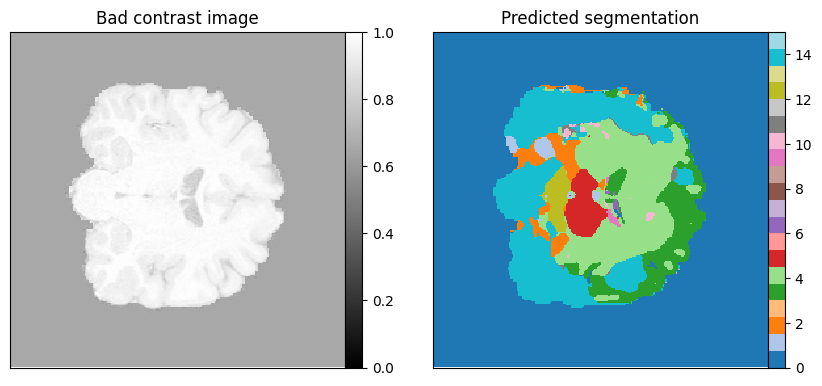

5it [00:31,  6.32s/it]

Gamma: 0.13513436116626068
Dice Score: 0.12094534188508987
zncc: 0.012905538082122803
sift: 1.3149121514288709e-05


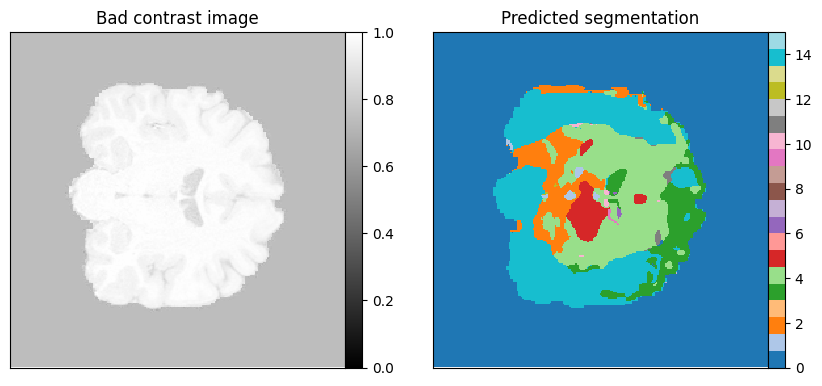

6it [00:38,  6.48s/it]

Gamma: 0.09743494403440249
Dice Score: 0.10345857590436935
zncc: 0.013933658599853516
sift: 1.4625719813921023e-05


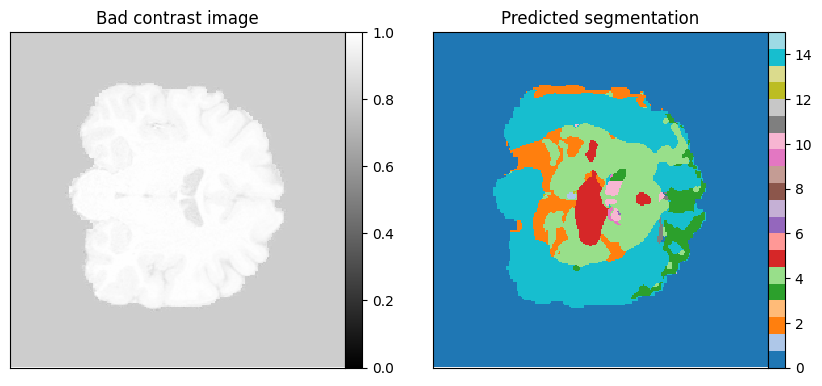

7it [00:44,  6.58s/it]

Gamma: 0.07025280792430623
Dice Score: 0.08521349728107452
zncc: 0.014690399169921875
sift: 1.581397737027146e-05


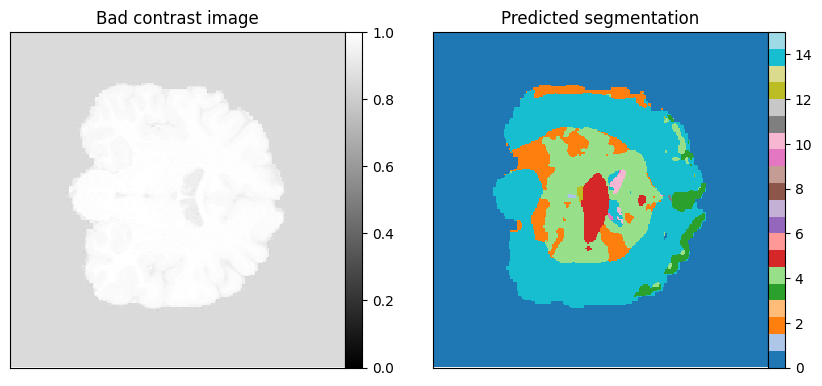

8it [00:51,  6.67s/it]

Gamma: 0.05065387033533725
Dice Score: 0.060281164944171906
zncc: 0.015243768692016602
sift: 1.6801055608084425e-05


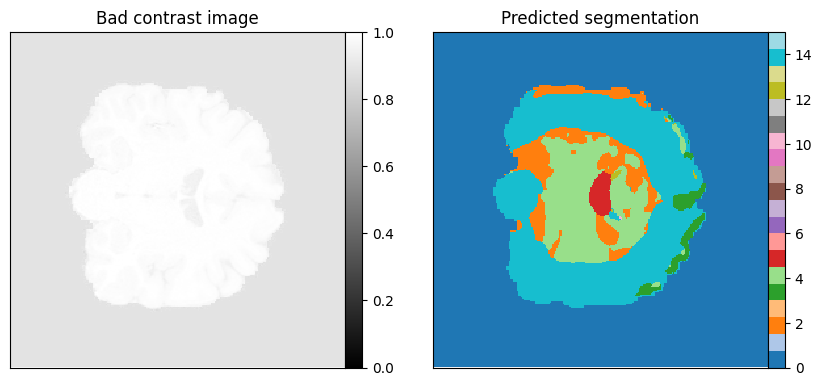

9it [00:58,  6.72s/it]

Gamma: 0.036522591135626795
Dice Score: 0.044860418885946274
zncc: 0.015646159648895264
sift: 1.767583489709068e-05


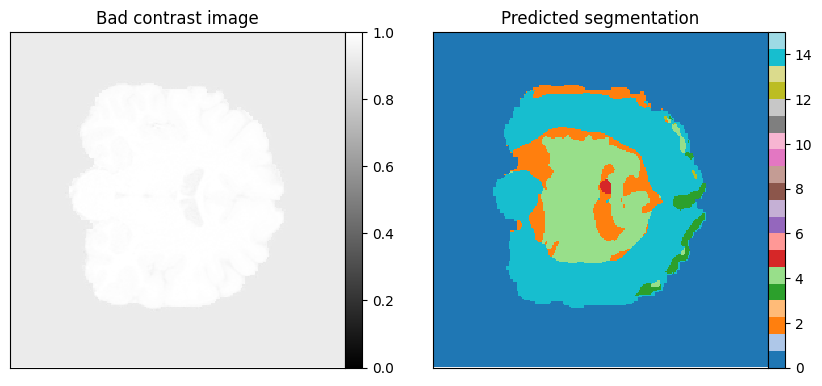

10it [01:03,  6.00s/it]

Gamma: 0.02633361783471869
Dice Score: 0.04261734336614609
zncc: 0.015938520431518555
sift: 1.8527765860198997e-05


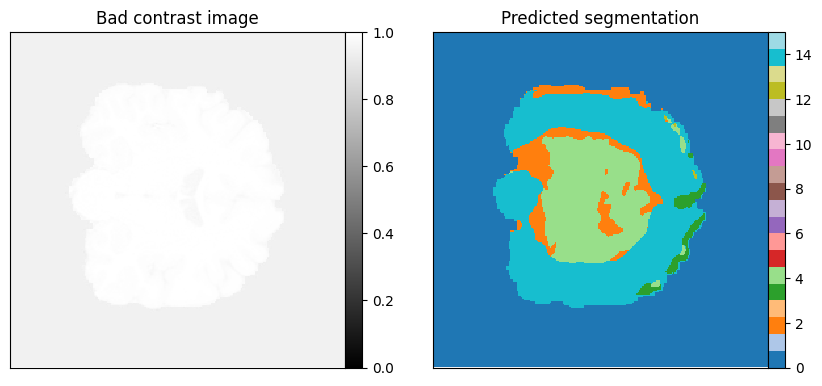

11it [01:09,  6.26s/it]

Gamma: 0.018987136637974283
Dice Score: 0.04318441078066826
zncc: 0.016150057315826416
sift: 1.9452132619335316e-05


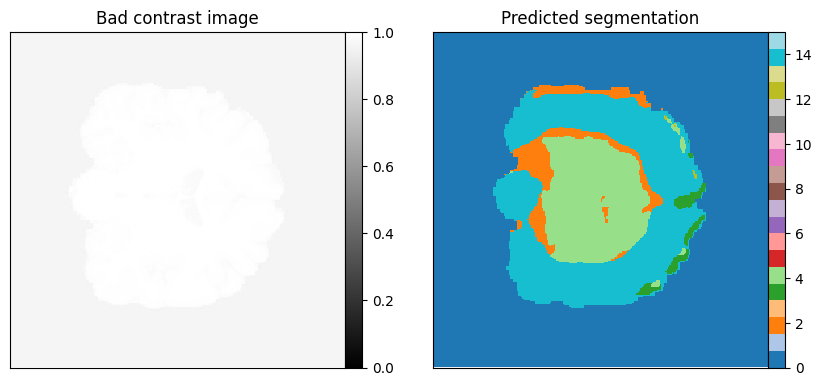

12it [01:15,  5.95s/it]

Gamma: 0.013690156816728805
Dice Score: 0.043693214654922485
zncc: 0.016303062438964844
sift: 2.0556763047352433e-05


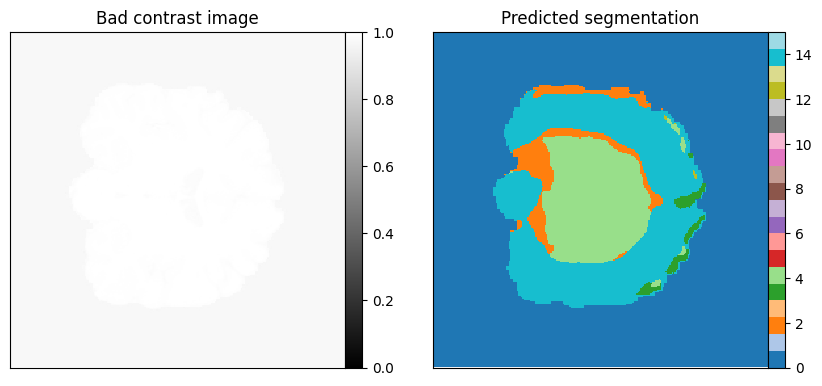

13it [01:21,  6.22s/it]

Gamma: 0.00987091404249892
Dice Score: 0.04393376037478447
zncc: 0.016414105892181396
sift: 2.197119829361327e-05


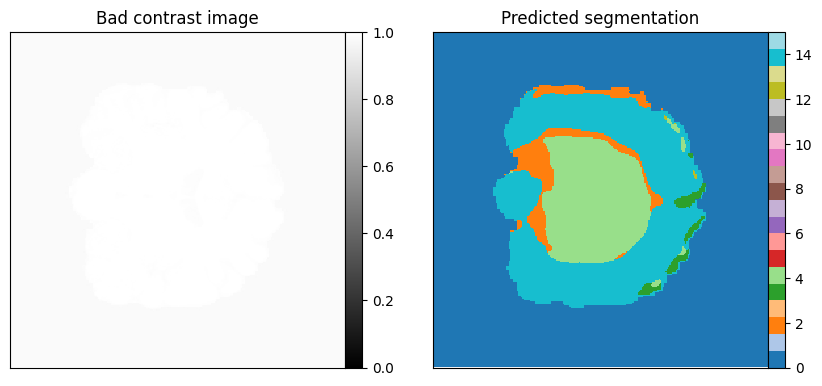

14it [01:28,  6.39s/it]

Gamma: 0.007117153246582319
Dice Score: 0.0440530963242054
zncc: 0.01649397611618042
sift: 2.385904372204095e-05


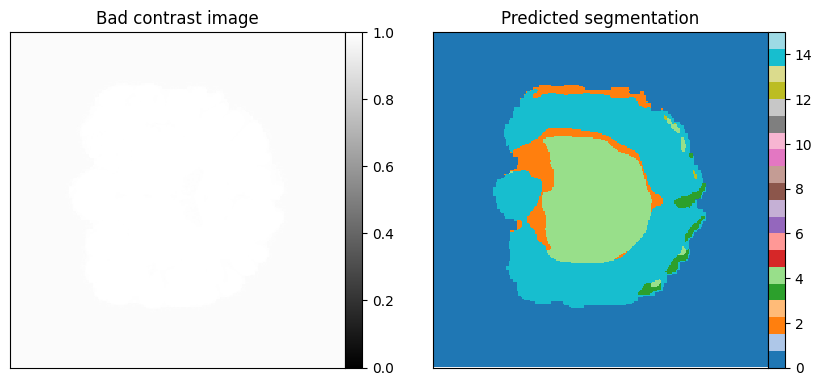

15it [01:35,  6.54s/it]

Gamma: 0.005131629159898318
Dice Score: 0.04415386915206909
zncc: 0.016551077365875244
sift: 2.643299194460269e-05


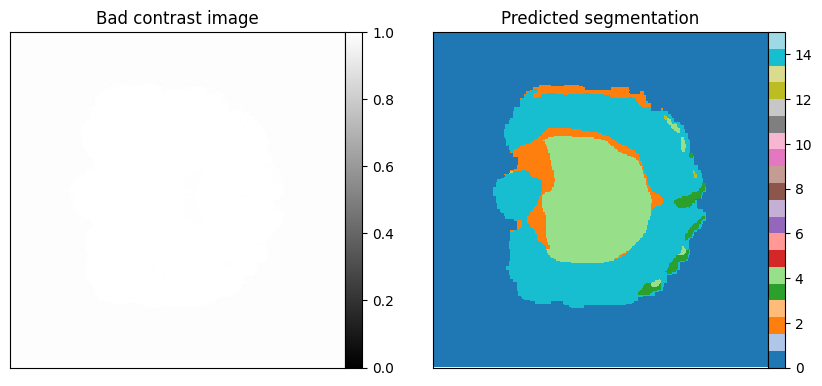

16it [01:42,  6.67s/it]

Gamma: 0.0037000211913891527
Dice Score: 0.04427614063024521
zncc: 0.016592860221862793
sift: 2.9966540751047432e-05


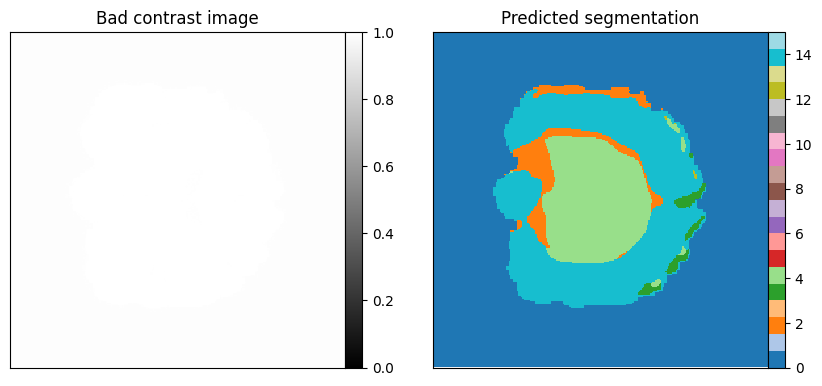

17it [01:48,  6.42s/it]

Gamma: 0.0026677993265203275
Dice Score: 0.044383466243743896
zncc: 0.016623198986053467
sift: 3.4820121072698385e-05


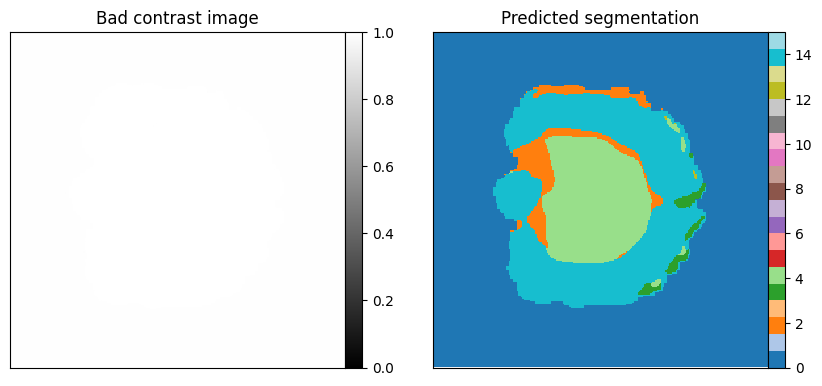

18it [01:55,  6.54s/it]

Gamma: 0.00192354391459856
Dice Score: 0.044458188116550446
zncc: 0.016644597053527832
sift: 4.143663318245672e-05


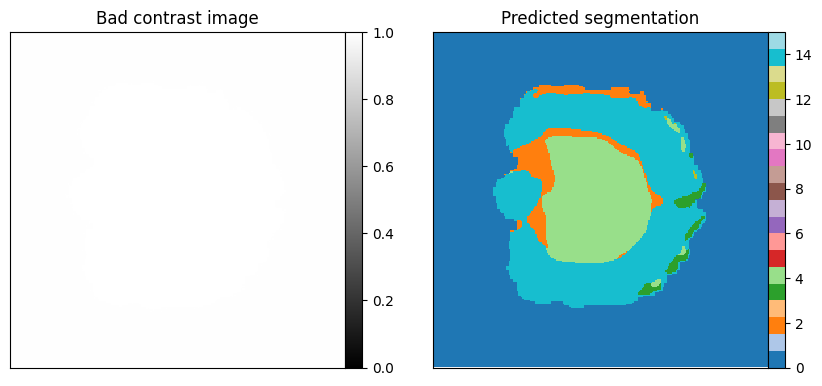

19it [02:02,  6.62s/it]

Gamma: 0.0013869188565300285
Dice Score: 0.04450168460607529
zncc: 0.016660213470458984
sift: 5.035163485445082e-05


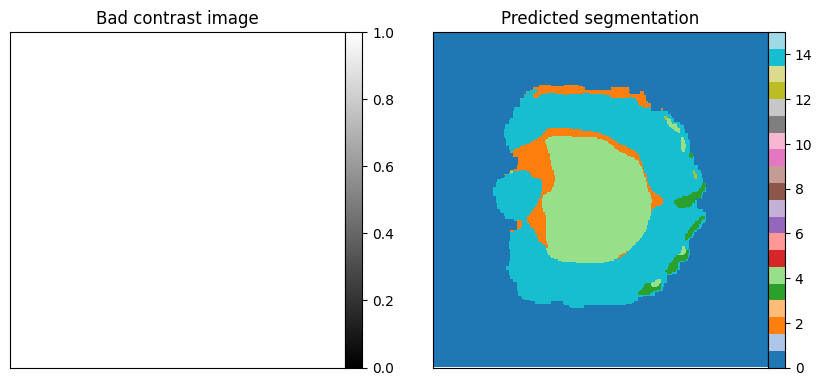

20it [02:08,  6.68s/it]

Gamma: 0.001
Dice Score: 0.044522762298583984
zncc: 0.016671419143676758
sift: 6.215542816789821e-05


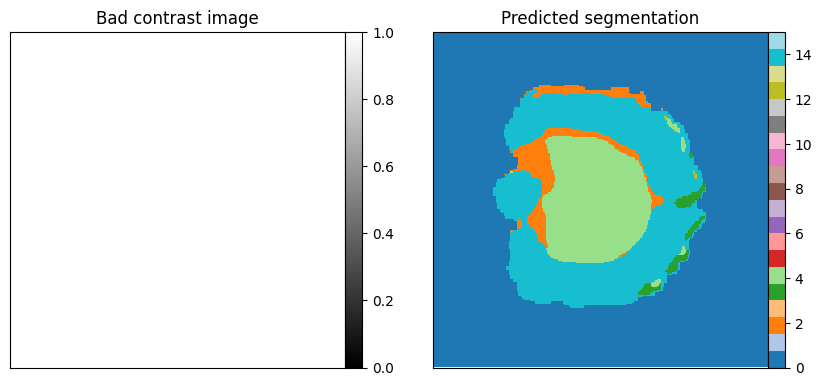

21it [02:15,  6.47s/it]


In [24]:
num_increments = 20
reg_losses_values = {k: [] for k in reg_losses.keys()}
dice_scores = []

gamma_max = 0.001
gamma_min = 0.5

# Do log sampling between 0.2 and 0.001
gammas = list(np.logspace(np.log10(0.001), np.log10(gamma_min), num=num_increments, base=10))
gammas.append(1.0)

# Iterate over increasing levels of bad contrast
for gamma in tqdm(reversed(gammas)):
    # apply bad contrast to normalized image without normalizing between 0 and 1
    img = gamma_contrast_change(nn_normalized_img_btw_0_1, gamma=gamma)
    
    # Measure regularization metric
    for reg_loss_name, reg_loss in reg_losses.items():
        reg_losses_values[reg_loss_name].append(reg_loss(nn_normalized_img_btw_0_1[None, None], img[None, None]).item())

    # Measure dice score between predicted segmentation over bad image and ground truth
    with torch.no_grad():
        mask, _ = seg(norm(gamma_contrast_change(original_img, gamma=gamma)[None, None]))
        _, dice_fg = dice_score(mask, y_gt_onehot)
        dice_scores.append(dice_fg.item())
    
    print(f'Gamma: {gamma}')
    print(f'Dice Score: {dice_fg.item()}')
    for reg_loss in reg_losses_values:
        print(f'{reg_loss}: {reg_losses_values[reg_loss][-1]}')
    plot_img_seg(
        img=img.squeeze(), seg=onehot_to_class(mask).squeeze(), n_classes=dataset_params['n_classes'],
        img_title='Bad contrast image', 
        seg_title='Predicted segmentation',
        intensity_range=(0., 1.)
        )

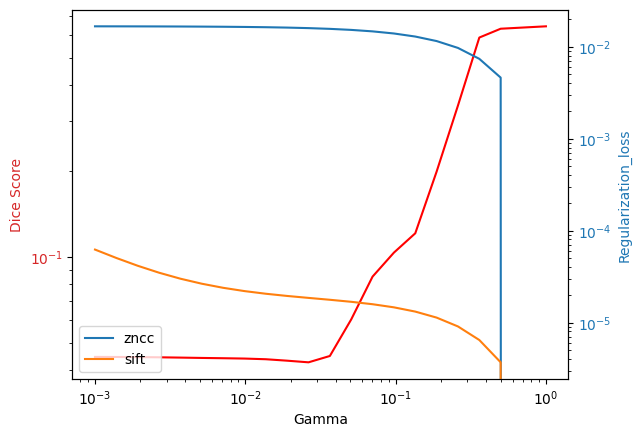

In [27]:
# Plot the regularization metrics and the dice scores  in the same line plot as a function of the bad contrast, use two y axes, one for gamma and one for the regularization metrics
fig, ax1 = plt.subplots()
ax1.set_xlabel('Gamma')
ax1.set_ylabel('Dice Score', color='tab:red')
ax1.plot(gammas[::-1], dice_scores, color='r')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.set_yscale('log')
ax1.set_xscale('log')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Regularization_loss', color='tab:blue')
for reg_loss_name in reg_losses_values:
    ax2.plot(gammas[::-1], reg_losses_values[reg_loss_name], label=reg_loss_name)
ax2.legend()
ax2.tick_params(axis='y', labelcolor='tab:blue')

# set ax2 y axis to log scale
ax2.set_yscale('log')

## Check bad contrast 